In [20]:
# !pip install pmdarima

In [21]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



In [22]:
data1 = pd.read_csv("JKH 2022-2023.csv")
data1.head()


,Day,High,Low,Close,No. of Trades,No. of Shares,Turnover(Rs.)
0,1/3/2022,153.25,149.0,152.75,321,799594,121924661
1,1/4/2022,153.25,149.0,149.50,177,317312,47828320
2,1/5/2022,151.75,147.0,150.75,232,1557752,234256848
3,1/6/2022,152.00,148.5,151.00,189,318537,47954695
4,1/7/2022,158.25,150.0,155.50,627,3343693,512681469


In [23]:
# df = data1.loc[5195:]
df = data1.iloc[:, :4]
df.head()

,Day,High,Low,Close
0,1/3/2022,153.25,149.0,152.75
1,1/4/2022,153.25,149.0,149.50
2,1/5/2022,151.75,147.0,150.75
3,1/6/2022,152.00,148.5,151.00
4,1/7/2022,158.25,150.0,155.50


In [24]:
# df['High'] = df['High'].astype(float)
# df['Low'] = df['Low'].astype(float)
# df['Closing'] = df['Closing'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     293 non-null    object 
 1   High    293 non-null    float64
 2   Low     293 non-null    float64
 3   Close   293 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.3+ KB


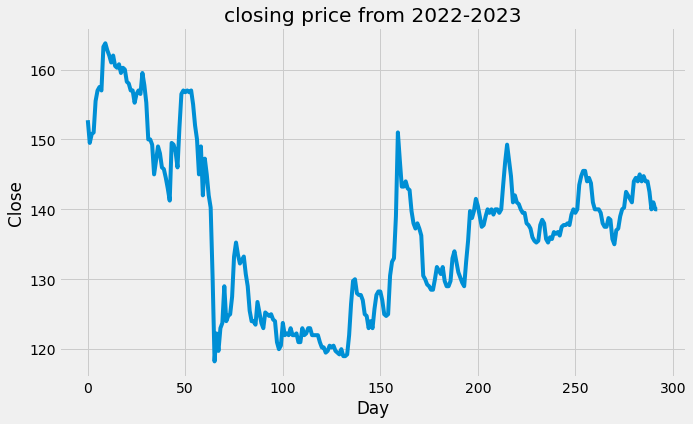

In [25]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Close')
plt.plot(df['Close'])
plt.title('closing price from 2022-2023')
plt.show()

<AxesSubplot:ylabel='Density'>

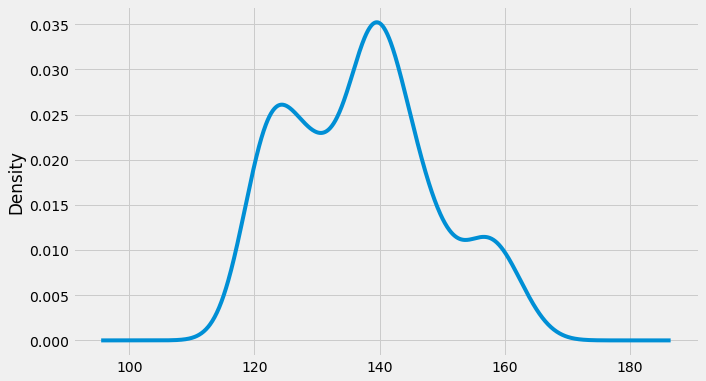

In [26]:
#Distribution of the dataset
df['Close'].plot(kind='kde')

In [27]:
df_close=df['Close']
df_close

0      152.75
1      149.50
2      150.75
3      151.00
4      155.50
        ...  
288    142.50
289    140.00
290    141.00
291    140.00
292    140.00
Name: Close, Length: 293, dtype: float64

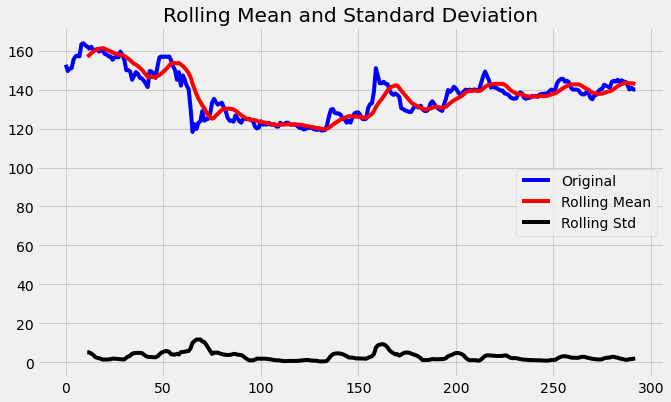

Results of dickey fuller test
Test Statistics                 -2.076754
p-value                          0.253964
No. of lags used                 1.000000
Number of observations used    291.000000
critical value (1%)             -3.453023
critical value (5%)             -2.871524
critical value (10%)            -2.572090
dtype: float64


In [28]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

In [29]:
# import numpy as np

# # Check for missing values and infinite values
# if np.isnan(exog).any() or np.isinf(exog).any():
#     # Handle missing and infinite values here (e.g., remove or impute)
#     exog = exog[~np.isnan(exog) & ~np.isinf(exog)]

# # Now, you can run the Dickey-Fuller test
# adft = adfuller(timeseries, autolag='AIC')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


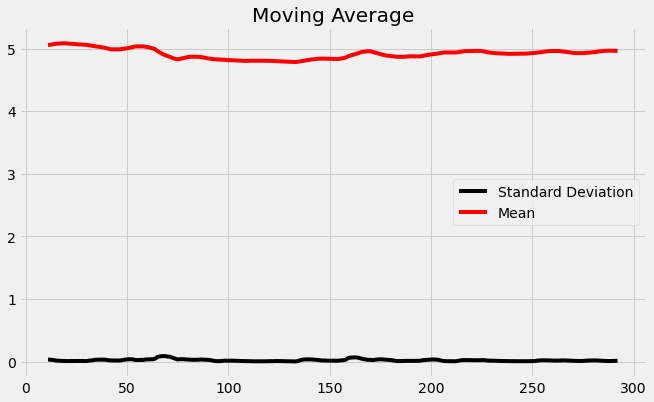

In [30]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

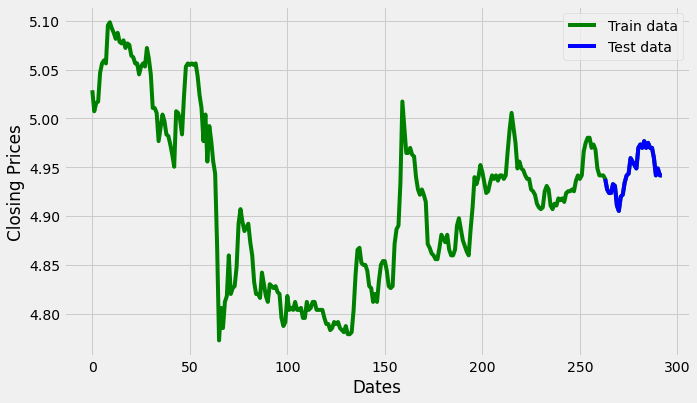

In [31]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1360.726, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1364.300, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1363.672, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1362.652, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1362.692, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1362.488, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1360.818, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1366.252, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1364.651, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1364.446, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1365.616, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1367.707, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-1362.317, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-1366.538, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0

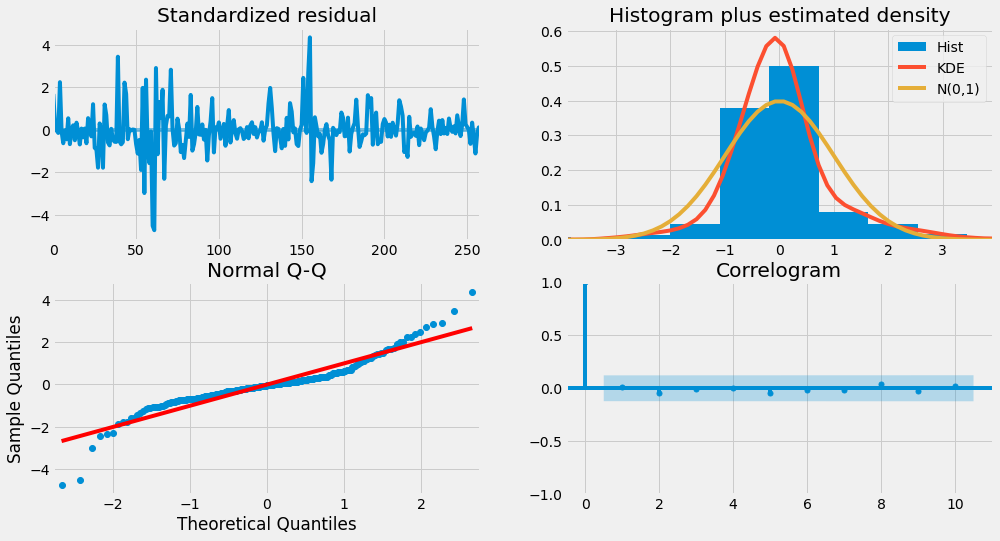

In [32]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [33]:
# #Modeling
# # Build Model
# model = ARIMA(train_data, order=(1,1,2))  
# fitted = model.fit(disp=-1)  
# print(fitted.summary())

In [34]:
from statsmodels.tsa.arima.model import ARIMA

# Modeling
# Build Model
model = ARIMA(train_data, order=(2, 1, 1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  260
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 687.854
Date:                Tue, 31 Oct 2023   AIC                          -1367.707
Time:                        22:19:19   BIC                          -1353.480
Sample:                             0   HQIC                         -1361.987
                                - 260                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6713      0.115     -5.850      0.000      -0.896      -0.446
ar.L2          0.2019      0.033      6.106      0.000       0.137       0.267
ma.L1          0.8231      0.118      6.999      0.0

In [35]:
# # Forecast
# fc, se, conf = fitted.forecast(59, alpha=0.05)  # 95% conf



# Forecast
forecast_values = fitted.forecast(steps=30, alpha=0.05)


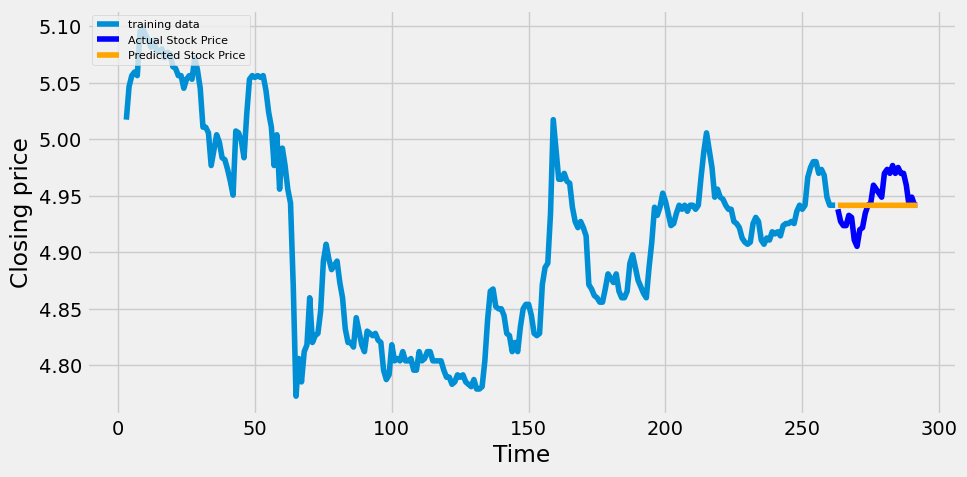

In [36]:
# Make as pandas series
fc_series = pd.Series(forecast_values, index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
# plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [37]:

# report performance
mse = mean_squared_error(test_data, forecast_values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast_values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast_values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.00042121095142766597
MAE: 0.016917332571311436
RMSE: 0.020523424456646264
MAPE: 0.0034178514379433105
